In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from scipy.signal import find_peaks
from scipy import conj,argmax

In [2]:
# Set the log file path
logFileName = '000-beetle-1.53-4.1'
logFileType = '.BBL'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

# Create decode command
decodeCommand = decodePath + ' ' + logFilePath
#print(cmd)

In [3]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) 
#df.head()
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
#print(time[0])
time=time-time[0]
#print(time)
diffOfTime = np.diff(time)
#print(diffOfTime)
averageUs = np.median(diffOfTime)
#print(averageUs)
samplingRate = 1000000/averageUs
print(samplingRate)

2000.0


In [4]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]
#print(setpointData)
#print(gyroADCData)
#print(gyroScaleData)
print(thrData)

[1000 1000 1000 ... 1000 1000 1000]


In [5]:
def smooth(x, wnd):
    # x: NumPy 1-D array containing the data to be smoothed
    # wnd: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(x,np.ones(wnd,dtype=int),'valid')/wnd
    r = np.arange(1,wnd-1,2)
    start = np.cumsum(x[:wnd-1])[::2]/r
    stop = (np.cumsum(x[:-wnd:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [6]:
def getStepInfo(frame):
    #To get settlingmax and settlingmin info
    #Noted that current method is not quite correct compare to the settlingmax and min theory in control theory
    #Need more work to improve this function
    step = (frame)
    step_tmp = -step + 2
    high_peaks, _ = find_peaks(step, height=0)
    low_peaks, _ = find_peaks(step_tmp, height=0)
    settling_max = max(step[high_peaks])
    #minpeak = avgmax(step[maxpeak])
    settling_min = min(step[low_peaks])
    return settling_max, settling_min

In [7]:
def calc_step_resp(axis):
    segment_length= int(samplingRate)*2 # 2 sec window
    wnd= int(samplingRate/2)            # 500ms time window for plotting step response  
    skipRate = 0.10

    gyro_signal = gyroADCData[axis]
    setpoint_signal = setpointData[axis]

    step_response = np.zeros((5000, segment_length), dtype=np.float64)

    seg_vector = range(0, len(gyro_signal)-segment_length, round(segment_length*skipRate))
    j = 0

    for i in seg_vector:
        Xseg = setpoint_signal[i:i+segment_length]
        if np.max(np.abs(Xseg)) < 15:
            continue
        if np.max(np.abs(Xseg)) > 400:
            continue
        Yseg = gyro_signal[i:i+segment_length]
        x_fft = rfft(np.hamming(segment_length) * Xseg)
        y_fft = rfft(np.hamming(segment_length) * Yseg)
        H=x_fft/len(x_fft)
        G=y_fft/len(y_fft)
        Hcon=np.conj(H)
        imp = np.real(irfft((G * Hcon) / (H * Hcon + .0001)))# impulse response function, .0001 to avoid divide by 0
        resp = np.cumsum(smooth(imp,21))
        resp = resp - resp[1]

        settling_max, settling_min = getStepInfo(resp)
        if settling_min>1 or settling_min<0.4 or settling_max>2 or settling_max<1:
            continue

        step_response[j,:] = resp
        j=j+1

        if j>=5000:
            break
    return j, wnd, step_response

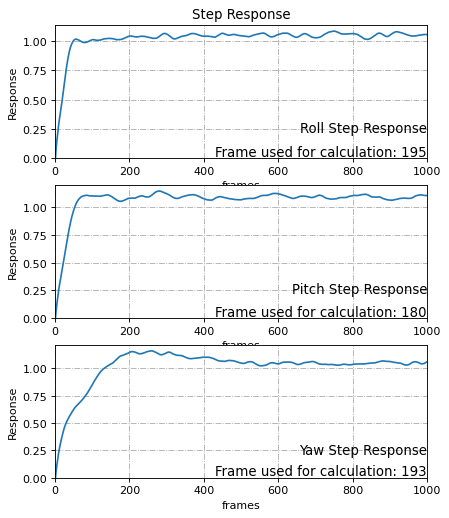

In [8]:
axis_name = ['Roll','Pitch','Yaw']

plt.figure(figsize=(6, 7.5), dpi= 80)

for i in range(0,3):
    j, wnd, step_resp = calc_step_resp(i)
    plt.subplot(3,1,i+1)
    settlingmax, settlingmin = getStepInfo((np.sum(step_resp[:j], axis=0)/j)[:wnd])
    ylim = settlingmax*1.05
    plt.text(1000, 0.02, "Frame used for calculation: %d"  %j, size= 'large', ha='right')
    plt.text(1000, 0.22, axis_name[i]+' Step Response', size= 'large', ha='right')
    if i ==0:
        plt.title('Step Response')
    plt.xlabel('frames')
    plt.xlim(0,wnd)
    # Noted that this xlim is frame number not time in ms
    # Need to fix this
    plt.ylabel('Response')
    plt.ylim(0,ylim)
    plt.plot((np.sum(step_resp[:j], axis=0)/j)[:wnd])
    plt.grid(True,linestyle='-.')
    del step_resp

plt.show()